# EDA on the cloud mask data
*by Max*

In this notebook I'll will do EDA on the cloud mask data.

We start with importing the modules and loading the data.

In [5]:
# import the needed modules
import numpy as np
import pandas as pd
import math

# import own modules from the scr folder
import sys
sys.path.append('../src/')
from train_test_function import train_test_split_fields

# Set a random seed
RSEED = 42
np.random.seed(RSEED)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import plotting modules and style
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(context='notebook', style='darkgrid', palette='crest', font='helvetica')
cmap = sns.color_palette('crest', as_cmap=True)
sns.set(rc={"figure.dpi":300})
sns.set(rc = {"figure.figsize":(6,3)})

In [2]:
# set the directory of the data 
OUTPUT_DIR = '../data'

# load the base data from the CSV files
df = pd.read_csv(f'{OUTPUT_DIR}/mean_band_perField_perDate.csv')
df.head()

,field_id,date,label,B02,B03,B04,B08,B11,B12,CLM
0,1,2017-04-01,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0
1,1,2017-04-11,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0
2,1,2017-04-21,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0
3,1,2017-05-01,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0
4,1,2017-05-11,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0


In [3]:
# convert the date column to datetime object
df['date'] = pd.to_datetime(df['date'])

# calculate the days from april as column to get a relative time
df['days_from_april'] =  df['date'] - pd.to_datetime('2017-04-01')
df['days_from_april'] = df['days_from_april'].dt.days

In [6]:
# Do the train-test-split
df_train, df_test = train_test_split_fields(df, train_size=0.7, random_state=RSEED)

We can see that we have different means for each of band over all the fields. Also the standard deviation is quiet different. B02, B03, B04, and B08 have higher stds compared to B11 and B12. It also seems like most bands have skewed distributions.

In [7]:
# descriptive statistics for the train data set
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
field_id,3011081.0,61522.439566,35324.479169,1.0,31097.000000,61389.000000,92075.000000,122736.0
label,3011081.0,4.356439,2.181953,1.0,3.000000,4.000000,6.000000,9.0
B02,3011081.0,57.167181,73.011264,0.0,13.312826,21.866667,63.429832,255.0
B03,3011081.0,63.935131,66.920963,0.0,22.855030,34.070255,69.083336,255.0
B04,3011081.0,70.078116,63.047463,0.0,28.795986,47.404408,80.209390,255.0
B08,3011081.0,99.083999,52.963478,0.0,66.943130,83.033540,110.469090,255.0
B11,3011081.0,89.900409,32.147673,0.0,67.625000,88.449440,111.147440,255.0
B12,3011081.0,70.378639,30.275073,0.0,47.898617,68.606064,91.149500,255.0
CLM,3011081.0,87.260245,120.983540,0.0,0.000000,0.000000,255.000000,255.0
days_from_april,3011081.0,135.985744,67.526041,0.0,90.000000,140.000000,195.000000,243.0


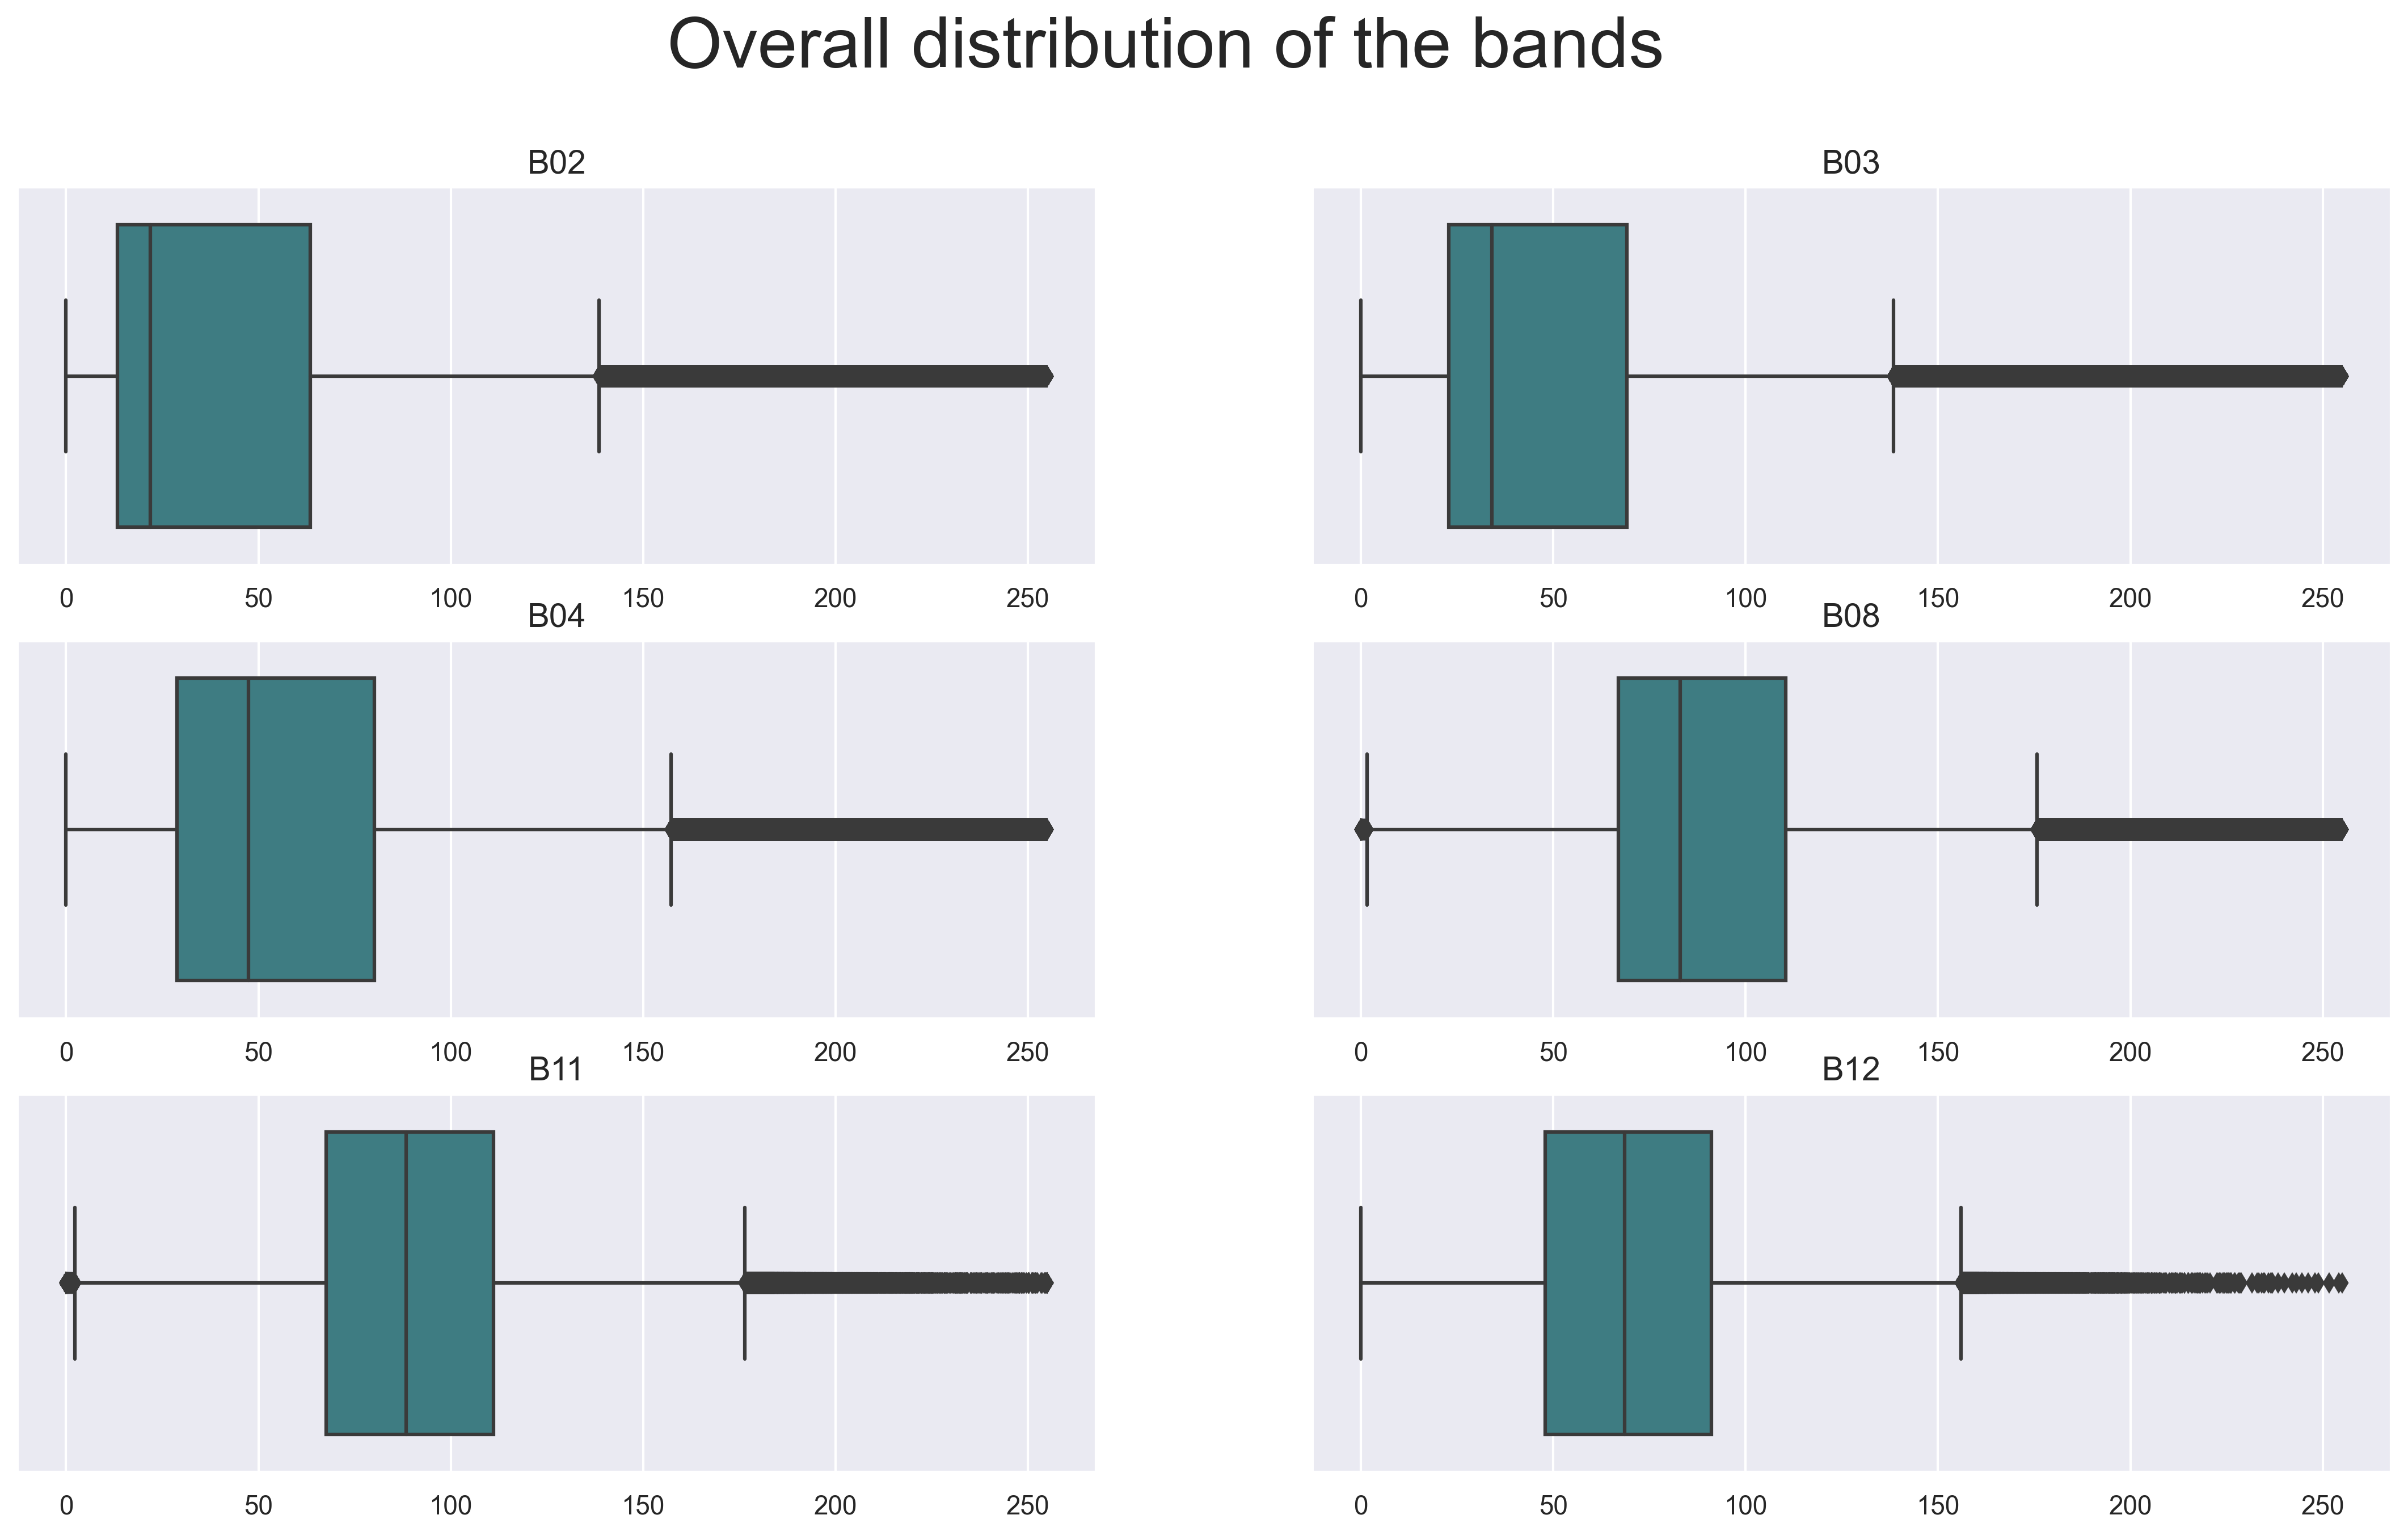

In [10]:
# create a list of the B0 bands
bands = df_train.columns.to_list()
for column in ['field_id', 'label', 'CLM', 'days_from_april', 'date']:
    bands.remove(column)

# set the big figure and axes
fig, axs = plt.subplots(3,math.ceil(len(bands)/3), figsize=(18,10))
fig.suptitle('Overall distribution of the bands', fontsize = 30)

# plot the different bands on the axes
for band, ax in zip(bands, axs.ravel()):
    sns.boxplot(x=band, hue='label', ax=ax, data=df_train, palette='crest')
    ax.set_title(band, fontsize=14)
    ax.set_xlabel('')
    
plt.show();

The CLM has only values between 0 and 255. And for the overall observations of the training data, there are 24% that are missing the cloud mask information.

In [14]:
df_train.CLM.unique()

array([255.,   0.])

In [28]:
print(f"Number of observations with no CLM info: {df_train[df_train['CLM']==255]['CLM'].count()}")
print(f"Number of overall observations: {df['CLM'].count()}")
print(f"Percent of data without information: {round(df_train[df_train['CLM']==255]['CLM'].count() / df['CLM'].count(), 4)*100}%")

Number of observations with no CLM info: 1030383
Number of overall observations: 4301227
Percent of data without information: 23.96%


In [12]:
# set the field id as data frame index
df_train_perID = df_train.set_index(['field_id'])

The next step is the plotting of the CLM information with regards to the label. We are interested in the distribution of unclouded and no information for each label. 

In [18]:
# create two series with the number of observations that are unclouded or have no CLM information 
unclouded_labels = df_train_perID[df_train_perID['CLM']==0].groupby('label')['label'] \
    .count()
noinfo_labels = df_train_perID[df_train_perID['CLM']==255].groupby('label')['label'] \
    .count()

# create a data frame of the two series
cloudmask_labels = pd.concat([unclouded_labels, noinfo_labels], axis=1)
cloudmask_labels.columns = ['unclouded', 'no information']
cloudmask_labels = cloudmask_labels.reset_index()
cloudmask_labels

,label,unclouded,no information
0,1,174328,96201
1,2,298246,166408
2,3,212417,96161
3,4,487280,259388
4,5,222285,101398
5,6,195327,105552
6,7,235027,132480
7,8,30467,17670
8,9,125321,55125


In [19]:
# melts the data frame in order to make it plot-able
cloudmask_labels = cloudmask_labels.melt(id_vars='label').rename(columns=str.title)
cloudmask_labels.columns = ['Label', 'CLM', 'Count']

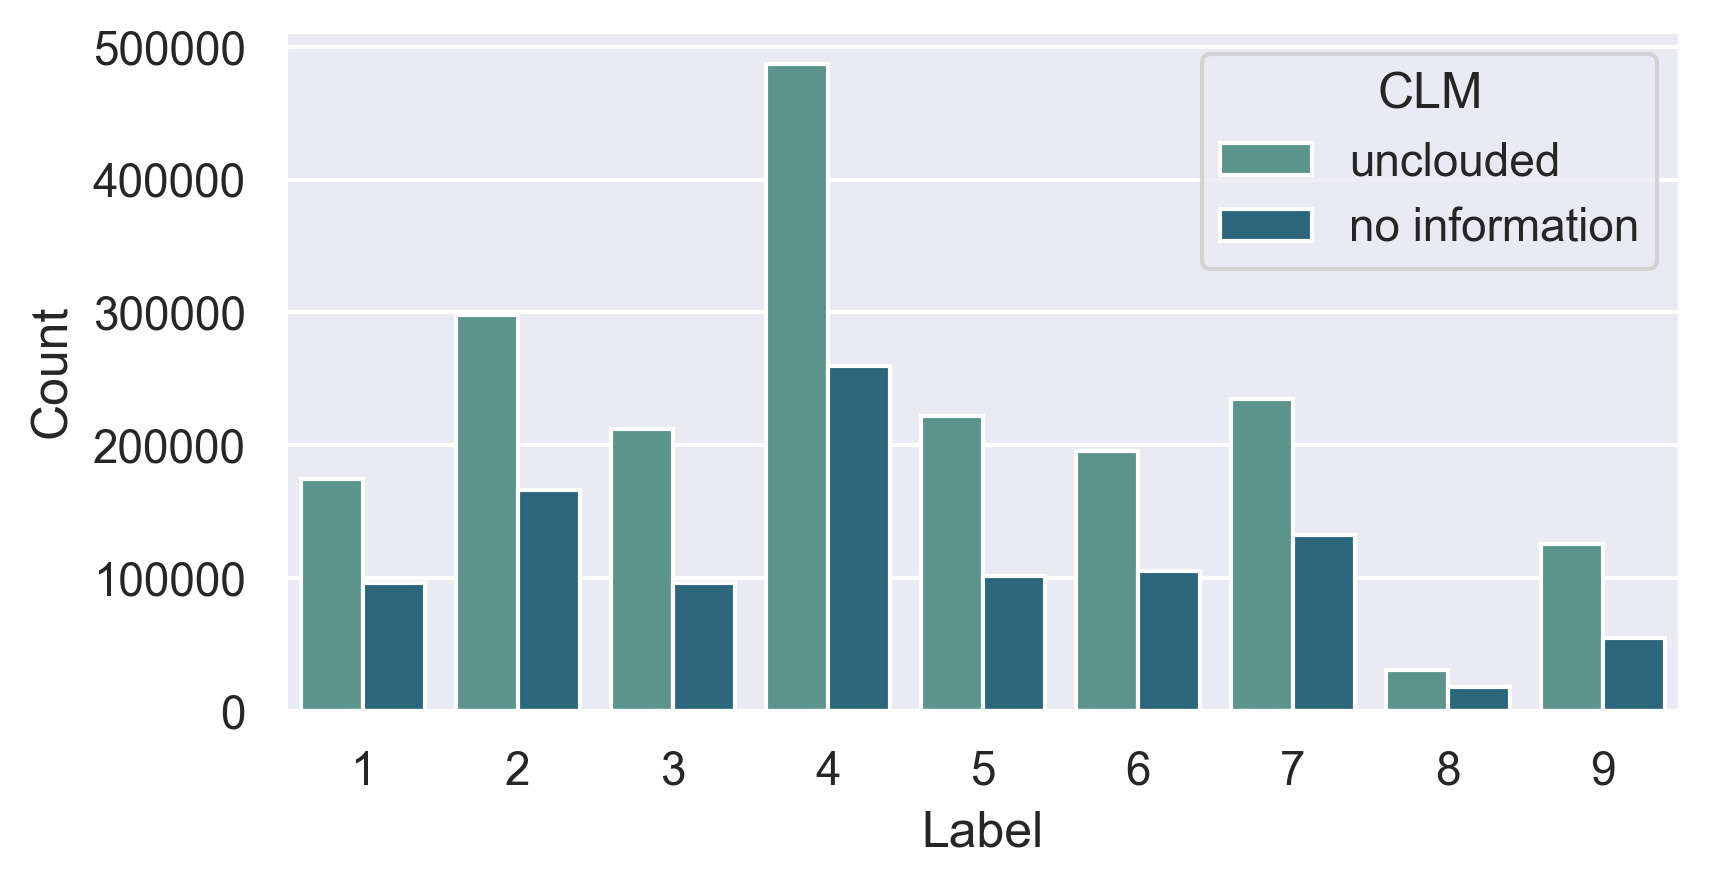

In [22]:
# plot the cloud mask info for each label 
sns.barplot(x='Label', y='Count', hue='CLM', palette='crest', data=cloudmask_labels)
plt.legend(title='CLM', loc='upper right');